In [119]:
import pandas as pd
import snorkel
import matplotlib.pyplot as plt
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
import seaborn as sns

In [359]:
# read in the training data
df_train = pd.read_csv("data/processed-labels/training_set_oradell.csv")
df_train.head()

,audit_task_id,label_id,gsv_panorama_id_x,label_type,severity,correct,high_quality_user,geometry,gsv_panorama_id_y,zoom,...,user_id,lat,lng,cluster_id,count,false_positive,distance,tag_list,description,tag_count
0,8,59,7l-j4D7uhfKRQPpYXIU59w,Obstacle,2.0,True,True,POINT (-74.03707122802734 40.94615936279297),7l-j4D7uhfKRQPpYXIU59w,3,...,503d2482-420f-454e-8118-aac2d22592aa,40.946159,-74.037071,115,8,0,10.614774,1.0,0.0,1.0
1,18,137,adXdsY189n44f0_ae5Hptg,NoCurbRamp,5.0,False,True,POINT (-74.03673553466797 40.96704864501953),adXdsY189n44f0_ae5Hptg,1,...,e86fdc72-c79d-4cdc-b5b2-8ef4859141d2,40.967049,-74.036736,403,6,0,1.638389,1.0,0.0,1.0
2,18,139,adXdsY189n44f0_ae5Hptg,SurfaceProblem,1.0,True,True,POINT (-74.03650665283203 40.96693420410156),adXdsY189n44f0_ae5Hptg,2,...,e86fdc72-c79d-4cdc-b5b2-8ef4859141d2,40.966934,-74.036507,162,10,0,21.534606,1.0,0.0,2.0
3,18,142,adXdsY189n44f0_ae5Hptg,SurfaceProblem,1.0,True,True,POINT (-74.03662109375 40.96712112426758),adXdsY189n44f0_ae5Hptg,2,...,e86fdc72-c79d-4cdc-b5b2-8ef4859141d2,40.967121,-74.036621,2233,4,0,34.130406,1.0,0.0,2.0
4,19,167,QnbhyLuq-5js6HTPvM7sKw,NoSidewalk,NaN,True,True,POINT (-74.03386688232422 40.96540451049805),QnbhyLuq-5js6HTPvM7sKw,1,...,e86fdc72-c79d-4cdc-b5b2-8ef4859141d2,40.965405,-74.033867,2886,2,0,6.722622,0.0,0.0,0.0


In [360]:
#select only label_type = curb ramp
# df_train = df_train[df_train['label_type'] == 'Crosswalk']

In [361]:
# read in gt.csv file
df_test = pd.read_csv('data/processed-labels/test_set_oradell.csv')
#select only label_type = curb ramp
# df_test = df_test[df_test['label_type'] == 'Crosswalk']
Y_test = df_test.verified.values

<AxesSubplot:>

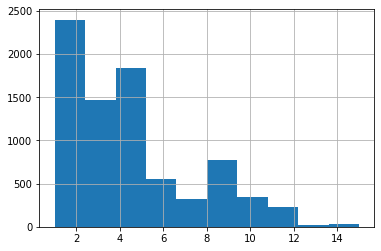

In [362]:
#plot cluster count for df train
df_train['count'].hist()

## Labeling functions based on heuristics

In [363]:
# Define the label mappings for convenience
NOT_SURE = -1
WRONG = 0
CORRECT = 1

### intersection

In [364]:
#check if it is in the curb false positive list
@labeling_function()
def intersection(x):
    # x in this case is a row of the dataframe
    return WRONG if x["false_positive"] == 1 else NOT_SURE

### cluster

In [365]:
#check if the label is in the cluster
@labeling_function()
def clustered(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['count'] >= 3 else NOT_SURE

### severity

In [366]:
#check if it is a severity 4 or higher
@labeling_function()
def severity(x):
    # x in this case is a row of the dataframe
    return CORRECT if x["severity"] >= 4 else NOT_SURE

### gsv

In [367]:
#check if the user zoomed in
@labeling_function()
def zoom(x):
    # x in this case is a row of the dataframe
    if x["zoom"] > 2:
        return CORRECT
    elif x["zoom"] == 1:
        return WRONG
    else:
        return NOT_SURE

### optional input

In [368]:
#check if the user has put a tag
@labeling_function()
def tags(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['tag_list']  == 1 else NOT_SURE

In [369]:
#check if the user has put a comment
@labeling_function()
def description(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['description']  == 1 else NOT_SURE

In [370]:
#check for distance to the curb
@labeling_function()
def distance(x):
    # x in this case is a row of the dataframe
    return WRONG if x['distance']  >= 35 else NOT_SURE

In [371]:
# lfs = [
#     intersection, 
#     zoom, 
#     tags, 
#     description,
#     severity,
#     clustered,
#     distance
#     ]


lfs = [
    intersection, 
    clustered,
    severity,
    zoom,
    tags, 
    description,
    distance
    ]

In [372]:
applier = PandasLFApplier(lfs=lfs)

In [373]:
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 4143/4143 [00:00<00:00, 38718.90it/s]


In [374]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
intersection,0,[0],0.050932,0.050932,0.050932
clustered,1,[1],0.699787,0.673883,0.489300
severity,2,[1],0.256539,0.256413,0.203729
zoom,3,"[0, 1]",0.793017,0.655988,0.522463
tags,4,[1],0.569641,0.540358,0.323739
description,5,[1],0.009886,0.009761,0.006257
distance,6,[0],0.119635,0.118759,0.112251


In [375]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [376]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.168]
INFO:root:[100 epochs]: TRAIN:[loss=0.010]
INFO:root:[200 epochs]: TRAIN:[loss=0.007]
INFO:root:[300 epochs]: TRAIN:[loss=0.007]
100%|██████████| 500/500 [00:00<00:00, 3330.67epoch/s]
INFO:root:Finished Training


In [377]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   77.2%
Label Model Accuracy:     70.2%
